# Intelligent Systems - Homework 1

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Problem 2

non-convex objective function to minimize:

$$f(x) = 2(x_1^2 + x_2^2) - 12x_2\sin(0.2\pi x_1) - x_1x_2$$

The minimum value of this function is around -14.75

In [2]:
def objective(state):
    x1, x2 = state[0], state[1]
    return 2*(x1**2 + x2**2) - 12*x2*np.sin(0.2*np.pi*x1) - x1*x2

### Part 1 - Newton's Method

In [3]:
def gradient_f(x):

    x1, x2 = x[0], x[1]
    df_dx1 = 4*x1 - 2.4*np.pi*x2*np.cos(0.2*np.pi*x1) - x2
    df_dx2 = 4*x2 - 12*np.sin(0.2*np.pi*x1) - x1
    return np.array([df_dx1, df_dx2])

def hessian_f(x):

    x1, x2 = x[0], x[1]
    df_dx1dx1 = 4 + 0.48*(np.pi**2)*x2*np.sin(0.2*np.pi*x1)
    df_dx1dx2 = -2.4*np.pi*np.cos(0.2*np.pi*x1) - 1
    df_dx2dx2 = 4

    return np.array([[df_dx1dx1, df_dx1dx2],
                     [df_dx1dx2, df_dx2dx2]])

In [4]:
def newton_optimization(objective, gradient, hessian, x_start,
                        movement_ratio=0.1, max_iterations=20, tol=1e-5):

    x = x_start
    for iteration in range(max_iterations):

        grad = gradient(x)
        if np.linalg.norm(grad) < tol:
            break

        hess = hessian(x)
        try: step = np.linalg.solve(hess, -grad)
        except: break

        x = x + movement_ratio * step

    return x, objective(x)

In [5]:
x_start = np.array([1.0, 3.0])

x_minimum, minimum_val = newton_optimization(
    objective, gradient_f, hessian_f, x_start=x_start,
    movement_ratio=1, max_iterations=20)

print(f'minimum value: {minimum_val:0.2f}')
print(f'x_min = [{x_minimum[0]:.2f}, {x_minimum[1]:.2f}]')

minimum value: 31006.83
x_min = [127.85, 29.22]


Since the function is non-convex, the Hessian matrix can be non-positive definite, which can lead to divergence of Newton's method.

In [6]:
h_start = hessian_f(x_start)
print(np.linalg.eigvals(h_start))

[16.41422555 -0.06048615]


Given the initial starting point mentioned in the problem, it's observed that the Hessian matrix has non-positive eigenvalues. As a result, the direction determined by Newton's method is not a descent direction, which implies that we should take smaller steps along the derived directions to avoid divergence when dealing with a non-positive definite Hessian matrix.

In [7]:
x_minimum, minimum_val = newton_optimization(
    objective, gradient_f, hessian_f, x_start=x_start,
    movement_ratio=0.1, max_iterations=40)

print(f'minimum value: {minimum_val:0.2f}')
print(f'x_min = [{x_minimum[0]:.2f}, {x_minimum[1]:.2f}]')

minimum value: -14.77
x_min = [-2.20, -3.51]


### Part 2 - Metaheuristic Method

In [8]:
# load my implementation of Simulated Annealing
from SimulatedAnnealing import SimulatedAnnealing

The problem instructs to explore the interval $\left[-15, 15\right]$ for both $x_1$ and $x_2$. The neighbors are selected based on a normal distribution centered around the current state by default. By setting the standard deviation of this distribution to 3, we can be sure that the entire interval will be explored.

In [9]:
optimizer = SimulatedAnnealing(objective, tempStart=1.0, neighborStd=3.0)

x_minimum, minimum_val = optimizer.run(np.array([0, 0]), 50000)
print(f'minimum value: {minimum_val:0.2f}')
print(f'x_min = [{x_minimum[0]:.2f}, {x_minimum[1]:.2f}]')

minimum value: -14.78
x_min = [-2.17, -3.45]


This can be confirmed by choosing a point far away, for example, $x_1 = 15$ and $x_2 = 15$. In doing so, we can observe that the optimization process still converges to the minimum.

In [10]:
x_minimum, minimum_val = optimizer.run(np.array([15, 15]), 50000)
print(f'minimum value: {minimum_val:0.2f}')
print(f'x_min = [{x_minimum[0]:.2f}, {x_minimum[1]:.2f}]')

minimum value: -14.77
x_min = [2.19, 3.43]


## Problem 3

In [11]:
from sklearn.model_selection import train_test_split

# load my implementation of Soft SVM
from SupportVectorMachine import SoftSVM

### Part 1

In [12]:
df = pd.read_csv('data.csv', index_col=0)
df.sample(n=4)

,sepal length,sepal width,class
36,5.5,3.5,Iris-setosa
83,6.3,2.8,Iris-virginica
30,4.8,3.1,Iris-setosa
65,6.4,3.2,Iris-virginica


In [13]:
class_names = df['class'].unique()
print(class_names)

['Iris-setosa' 'Iris-virginica']


In [14]:
X = df.drop(columns=['class']).to_numpy()
y = pd.Categorical(df['class']).codes
# convert the labels from [0, 1] to [-1, +1]
y = y * 2 - 1

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (98, 2)
y shape: (98,)


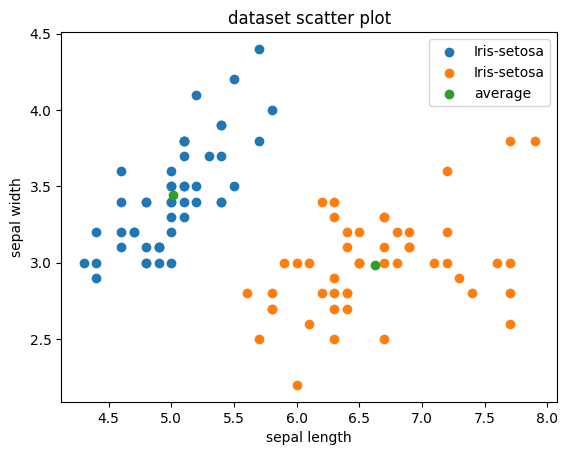

In [15]:
def scatter_plot(X, y):

    X1, X2 = X[y==-1], X[y==1]
    mean = np.array([X1.mean(axis=0), X2.mean(axis=0)])

    plt.scatter(X1[:, 0], X1[:, 1], label=class_names[0])
    plt.scatter(X2[:, 0], X2[:, 1], label=class_names[0])
    plt.scatter(mean[:, 0], mean[:, 1], label='average')
    plt.title('dataset scatter plot')
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.show()

scatter_plot(X, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2)

print('train shape:', X_train.shape, y_train.shape)
print('test shape:', X_test.shape, y_test.shape)

train shape: (78, 2) (78,)
test shape: (20, 2) (20,)


### Part 2

__Loss Function:__

The Soft Margin Support Vector Machine loss function is a combination of the hinge loss and L2 regularization.

$$\text{Loss} = \frac{1}{2}\|w\|^2 + C \sum_{i=1}^{N} \max\left(0, 1 - y_i(w^T \cdot X_i + b)\right)$$

The "max" function ensures that the loss is only computed for data points that are not correctly outside the support vectors.

__Weight Updates:__

The gradient of the hinge loss with respect to the weights and bias is computed for the samples that are not outside the support vectors.

$$\Delta w = w - C \cdot \sum_{\text{misclassified}} y_i X_i$$

$$\Delta b = -C \cdot \sum_{\text{misclassified}} y_i$$

The weights ($w$) and bias ($b$) are updated using gradient descent with the following formulas:

$$w \leftarrow w - \text{learning rate} \cdot \Delta w$$

$$b \leftarrow b - \text{learning rate} \cdot \Delta b$$

The Soft SVM implementation aims to find a set of weights and a bias that minimize the loss function while encouraging a margin of separation between the classes and penalizing misclassifications.

### Part 3

Increasing the hyperparameter $C$ encourages the model to adjust the Hyperplane in a way that data points are positioned outside the support vector zone. Conversely, reducing $C$ places more priority on maximizing the margin.

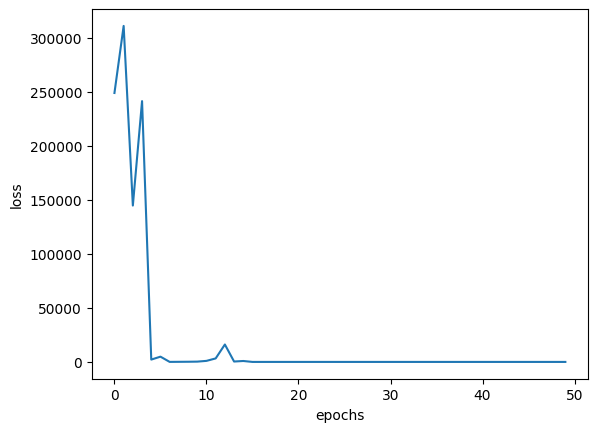

In [17]:
svm = SoftSVM(X.shape[1], C=500)
train_loss = svm.fit(X_train, y_train,
    learning_rate=1e-4, epochs=50, batch_size=16)

plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [18]:
print(f'w = [{svm.w[0]:.4f}, {svm.w[1]:.4f}]')
print(f'b = {svm.b:.4f}')

w = [4.3588, -7.1818]
b = -1.5431


In [19]:
test_loss = svm.loss(y_test, svm.distance(X_test))
print(f'loss on test data: {test_loss:.2f}')

yp = svm.predict(X_test)
test_accuracy = np.count_nonzero(yp == y_test) / len(y_test)
print(f'accuracy on test data: {test_accuracy*100:.1f} %')

loss on test data: 35.29
accuracy on test data: 100.0 %


### Part 4

In [20]:
def scatter_plot(X, y):

    X1, X2 = X[y==-1], X[y==1]
    tx = np.arange(4.3, 8, 0.1)
    ty = -svm.w[0] / svm.w[1] * tx - svm.b / svm.w[1]
    ty1 = ty - 1  / svm.w[1]
    ty2 = ty + 1  / svm.w[1]

    plt.scatter(X1[:, 0], X1[:, 1], label=class_names[0])
    plt.scatter(X2[:, 0], X2[:, 1], label=class_names[0])
    plt.plot(tx, ty1)
    plt.plot(tx, ty2)
    plt.plot(tx, ty)
    plt.title('svm decision boundary')
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.show()

Below, we observe that all data points are correctly positioned outside the support vector zone and the margin is effectively maximized. If we were to use a significantly lower value for $C$, the margin would be larger, but a few data points would fall within the support vector zone.

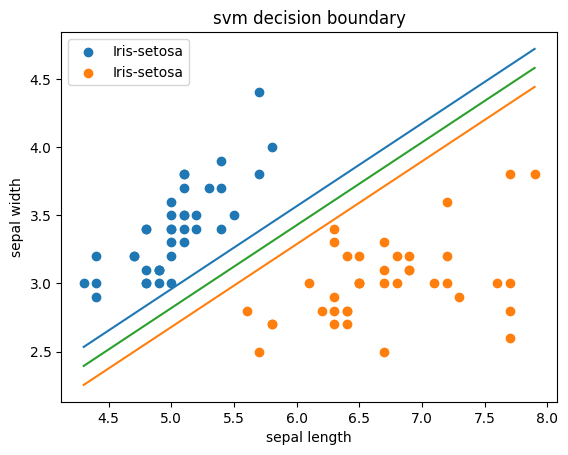

In [21]:
scatter_plot(X_train, y_train)

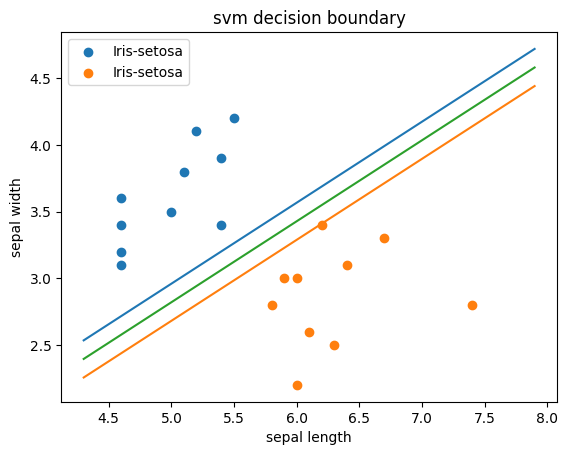

In [22]:
scatter_plot(X_test, y_test)